In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import sys

sys.path.append('..')

from sast import *

# Configs

In [2]:
use_rocket = True # use ROCKET if True otherwise use SAST
data_file = 'beflowtkd-export.json'
max_length = 16 # max length of time series

In [3]:
# define the key points to consider
all_key_points = ['rightEye', 'leftEye', 'leftAnkle', 'rightAnkle', 'leftEar', 'rightEar', 'leftElbow', 'rightElbow', 'leftHip', 'rightHip', 'leftKnee', 'rightKnee', 'leftShoulder', 'rightShoulder', 'leftWrist', 'rightWrist', 'nose']
ignored_key_points = set(['rightEye', 'leftEye'])
key_points = list(filter(lambda x: x not in ignored_key_points, all_key_points))

# Dataset

In [4]:
tkd_raw_data = pd.read_json(data_file)
tkd_raw_data

counters            description  \
ap_chagi               40  Tkd moves time series   
bandal_chagi           40  Tkd moves time series   
dwi_huryo_chagi        40  Tkd moves time series   

                                                             moves  
ap_chagi         {'-MQgr-qd8xkXlgAzU_Qo': {'confidence': '0.959...  
bandal_chagi     {'-MQgswQfPw9gnraQQ2i4': {'confidence': '0.929...  
dwi_huryo_chagi  {'-MRfVSa7UC48EhapAYXK': {'confidence': '0.931...

In [5]:
classes = tkd_raw_data.index.tolist()
print(classes)

['ap_chagi', 'bandal_chagi', 'dwi_huryo_chagi']


In [6]:
classes2int = {c: i for i, c in enumerate(classes)}
print(classes2int)

{'ap_chagi': 0, 'bandal_chagi': 1, 'dwi_huryo_chagi': 2}


In [7]:
int2classes = {i: c for i, c in enumerate(classes)}
print(int2classes)

{0: 'ap_chagi', 1: 'bandal_chagi', 2: 'dwi_huryo_chagi'}


## Visualization

In [8]:
tkd_raw_data.loc['ap_chagi']

counters                                                      40
description                                Tkd moves time series
moves          {'-MQgr-qd8xkXlgAzU_Qo': {'confidence': '0.959...
Name: ap_chagi, dtype: object

In [25]:
str(tkd_raw_data.loc['ap_chagi'].moves['-MQgr-qd8xkXlgAzU_Qo'])

"{'confidence': '0.959,0.932,0.938,0.945,0.945,0.934,0.943,0.951,0.954,0.92,0.9,0.915,0.903,0.901,0.896,0.94,0.943,0.936,0.943,0.936,0.937', 'leftAnkle': {'confidence': '0.984,0.96,0.961,0.958,0.98,0.962,0.982,0.969,0.924,0.713,0.731,0.88,0.418,0.739,0.429,0.98,0.982,0.974,0.968,0.929,0.923', 'x': '0.573,0.537,0.548,0.55,0.557,0.551,0.56,0.557,0.554,0.521,0.519,0.528,0.527,0.534,0.524,0.524,0.539,0.543,0.55,0.543,0.555', 'y': '0.724,0.69,0.675,0.677,0.68,0.679,0.674,0.674,0.676,0.698,0.707,0.706,0.691,0.684,0.69,0.675,0.668,0.673,0.67,0.691,0.704'}, 'leftEar': {'confidence': '0.846,0.686,0.721,0.675,0.752,0.533,0.475,0.586,0.689,0.764,0.669,0.611,0.885,0.903,0.743,0.562,0.694,0.744,0.679,0.689,0.695', 'x': '0.554,0.513,0.518,0.521,0.524,0.521,0.524,0.528,0.543,0.548,0.549,0.562,0.56,0.562,0.565,0.55,0.527,0.529,0.527,0.527,0.533', 'y': '0.294,0.274,0.27,0.277,0.279,0.271,0.276,0.275,0.261,0.263,0.274,0.269,0.261,0.256,0.261,0.265,0.265,0.263,0.269,0.285,0.29'}, 'leftElbow': {'confidenc

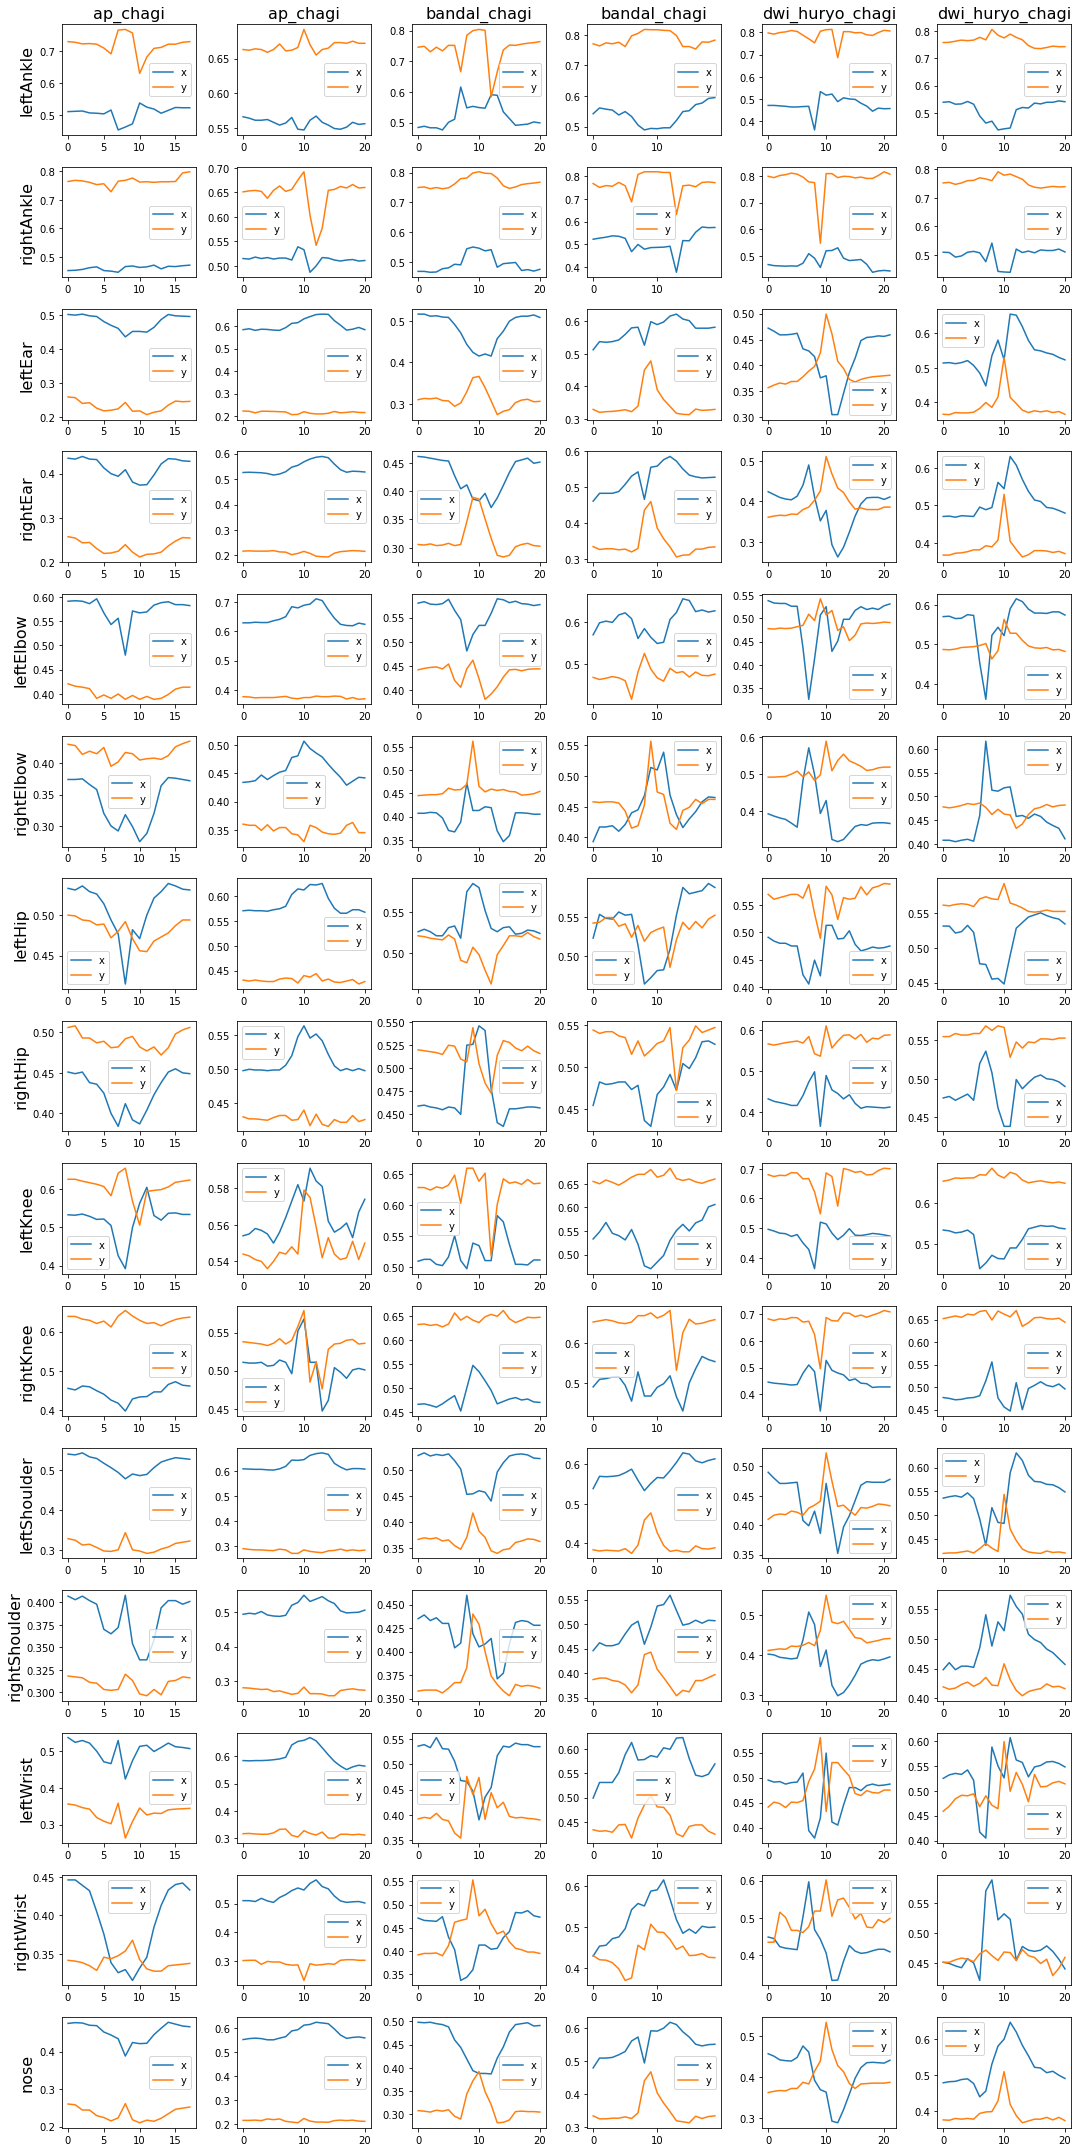

In [9]:
nb_moves_per_class = 2

fig, axes = plt.subplots(ncols=len(classes) * nb_moves_per_class, nrows=len(key_points), figsize=(15, 30), tight_layout=True, sharex=False)

for j, c in enumerate(classes):
    moves = np.random.choice(list(tkd_raw_data.loc[c].moves.values()), size=nb_moves_per_class, replace=False)
    while any(map(lambda x: len(x['confidence']) == 0, moves)):
        moves = np.random.choice(list(tkd_raw_data.loc[c].moves.values()), size=nb_moves_per_class, replace=False)
    for i, kp in enumerate(key_points):
        for k, move in enumerate(moves):
            col = j * nb_moves_per_class + k
            axes[i, col].plot(np.fromstring(move[kp]['x'], sep=','), label='x')
            axes[i, col].plot(np.fromstring(move[kp]['y'], sep=','), label='y')
            axes[i, col].legend()
            if col == 0:
                axes[i, col].set_ylabel(kp, fontsize=16)
            if i == 0:
                axes[i, col].set_title(c, fontsize=16)

# Format the dataset

In [9]:
def format_series(series, max_length):
    series_len = len(series)
    if series_len < max_length:
        series = np.concatenate([series, [np.mean(series)] * (max_length - series_len)])
    return np.array(series, dtype=np.float32)

def format_json_move(move, max_length):
    output_data = {}
    for kp in key_points:
        x_series = np.array(move[kp]['x'].split(','), dtype=np.float32)
        y_series = np.array(move[kp]['y'].split(','), dtype=np.float32)
        output_data[f'{kp}_x'] = format_series(x_series, max_length)
        output_data[f'{kp}_y'] = format_series(y_series, max_length)
    return output_data

In [10]:
tkd_data_dict = {f'{kp}_x': [] for kp in key_points} # the x-axis
tkd_data_dict.update({f'{kp}_y': [] for kp in key_points}) # the y-axis
tkd_data_class_dict = {kp: [] for kp in key_points} # the class label (move's name)
for c, row in tkd_raw_data.iterrows():
    for _, move in row.moves.items():
        if len(move['confidence']) == 0:
            continue
        for kp in key_points:
            x_series = np.array(move[kp]['x'].split(','), dtype=np.float32)
            y_series = np.array(move[kp]['y'].split(','), dtype=np.float32)
            tkd_data_dict[f'{kp}_x'].append(x_series)
            tkd_data_dict[f'{kp}_y'].append(y_series)
            tkd_data_class_dict[kp].append(classes2int[c])
            max_length = max(max_length, len(x_series))
            max_length = max(max_length, len(y_series))
print(max_length)

32


In [11]:
for k, data in tkd_data_dict.items():
    tmp = np.zeros((len(data), max_length), dtype=np.float64)
    for i in range(len(data)):
        series = format_series(data[i], max_length)
        tmp[i] = series
    tkd_data_dict[k] = tmp

# Building and train the model

In [12]:
def create_model(trainX, trainy, max_length):
    #     clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
    clf = RandomForestClassifier()
    model = None
    if use_rocket:
        model = RocketClassifier(clf=clf, lr_clf=False)
    else:
        model = SAST(cand_length_list=np.arange(3, max_length + 1),
                          nb_inst_per_class=1, classifier=clf)
    model.fit(trainX, trainy)
    
    return model

In [13]:
model = {}

start_time = time.time()

for key in key_points:
    model[f'{key}_x'] = create_model(tkd_data_dict[f'{key}_x'], tkd_data_class_dict[key], max_length)
    model[f'{key}_y'] = create_model(tkd_data_dict[f'{key}_y'], tkd_data_class_dict[key], max_length)

end_time = time.time()
print('Model built and trained in', end_time - start_time, 'seconds')

Model built and trained in 23.05459713935852 seconds


In [14]:
def predict_move(model, move):
    predictions = []
    for key, m in model.items():
        predictions.append(m.predict_proba(np.expand_dims(move[key], axis=0).astype(np.float64)))
    predictions = np.mean(predictions, axis=0)
    return np.argmax(predictions), np.max(predictions) * 100

# Model score on training data

In [15]:
pred = []
for key in key_points:
    pred.append(model[f'{key}_x'].predict_proba(tkd_data_dict[f'{key}_x']))
    pred.append(model[f'{key}_y'].predict_proba(tkd_data_dict[f'{key}_y']))

pred = np.argmax(np.mean(pred, axis=0), axis=1)
P, R, F1, _ = precision_recall_fscore_support(tkd_data_class_dict[key], pred, average='macro')
print("Precision:", P)
print("Recall:", R)
print("F1-score:", F1)
confusion_matrix(tkd_data_class_dict[key], pred)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


array([[40,  0,  0],
       [ 0, 40,  0],
       [ 0,  0, 40]])

# Some predictions

In [16]:
keys = list(tkd_raw_data.loc['ap_chagi'].moves.keys())
for k in np.random.choice(keys, size=3):
    formated_move = format_json_move(tkd_raw_data.loc['ap_chagi'].moves[k], max_length)
    pred, confidence = predict_move(model, formated_move)
    print('Prediction:', int2classes[pred], 'Confidence:', confidence)

Prediction: ap_chagi Confidence: 79.86666666666667
Prediction: ap_chagi Confidence: 85.06666666666666
Prediction: ap_chagi Confidence: 86.16666666666666


In [17]:
keys = list(tkd_raw_data.loc['bandal_chagi'].moves.keys())
for k in np.random.choice(keys, size=3):
    formated_move = format_json_move(tkd_raw_data.loc['bandal_chagi'].moves[k], max_length)
    pred, confidence = predict_move(model, formated_move)
    print('Prediction:', int2classes[pred], 'Confidence:', confidence)

Prediction: bandal_chagi Confidence: 84.93333333333332
Prediction: bandal_chagi Confidence: 81.16666666666664
Prediction: bandal_chagi Confidence: 85.56666666666668


# Saving the models

In [18]:
from joblib import dump

In [19]:
for key in key_points:
    dump(model[f'{key}_x'], f'models/multivariate/tkd_model_{key}_x_rocket.joblib')
    dump(model[f'{key}_y'], f'models/multivariate/tkd_model_{key}_y_rocket.joblib')